# Analyzing fire department payrolls in L.A.: 2011-2018

This notebook analyzes annual government payroll [data](https://publicpay.ca.gov/Reports/RawExport.aspx) compiled and released annually by the California state controller's office. The data include anonymized salary information for all employees at cities, counties, special districts and state government. 

---

### Load python tools

In [1]:
import pandas as pd
import geopandas as gpd
import cpi
from urllib.request import urlopen 
import pyarrow
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.float_format = '{:,.0f}'.format

### Import fire payroll data

In [2]:
# processed in 01-california-payroll-descriptives
agency_ot = pd.read_csv('output/agency_overtime.csv')
agency_ot_share = pd.read_csv('output/agency_overtime_share_ot.csv')
payroll_fire = pd.read_csv('/Users/mhustiles/data/data/controller/output/payroll_fire.csv')

---

### Filter dataframe to include only Los Angeles city and county fire

In [3]:
la = payroll_fire[payroll_fire['employer'] == 'LOS ANGELES']

In [4]:
la.head(1)

,Unnamed: 0,index,year,type,population,employer,department,position,overtime,wages,benefits,employercounty,basewages,adjusted_overtime,adjusted_wages,adjusted_benefits,adjusted_basewages,employerfull
18989,970571,970571,2018,CITY,"4,040,079",LOS ANGELES,FIRE,APPARATUS OPERATOR,"27,902","145,581","70,947",LOS ANGELES,"117,679","27,902","145,581","70,947","117,679",LOS_ANGELES_CITY


In [5]:
la.groupby(['employerfull', 'year']).agg({'adjusted_overtime':'sum', 'adjusted_basewages':'sum'}).reset_index()

,employerfull,year,adjusted_overtime,adjusted_basewages
0,LOS_ANGELES_CITY,2011,"106,442,381","396,306,323"
1,LOS_ANGELES_CITY,2012,"122,766,643","377,794,902"
2,LOS_ANGELES_CITY,2013,"150,689,736","372,589,009"
3,LOS_ANGELES_CITY,2014,"170,170,047","333,382,422"
4,LOS_ANGELES_CITY,2015,"194,577,723","375,669,446"
5,LOS_ANGELES_CITY,2016,"193,805,688","377,712,120"
6,LOS_ANGELES_CITY,2017,"200,297,491","398,616,488"
7,LOS_ANGELES_CITY,2018,"194,037,539","399,477,016"
8,LOS_ANGELES_COUNTY,2011,"140,594,166","329,392,322"
9,LOS_ANGELES_COUNTY,2012,"145,007,457","322,618,544"


---

### Create a dataframe combining and pivoting listing all the large places

In [6]:
la_pivot_ot = pd.DataFrame(pd.pivot_table(la, \
                values='adjusted_overtime', index=['employer', 'type'], columns=['year']).reset_index().fillna(0))

In [7]:
la_pivot_ot.columns = la_pivot_ot.columns.map(str)

In [8]:
la_pivot_ot['adjusted_ot_pct_change'] = \
                ((la_pivot_ot['2018']-la_pivot_ot['2011'])/\
                 la_pivot_ot['2011'])*100

In [9]:
la_pivot_ot.head()

year,employer,type,2011,2012,2013,2014,2015,2016,2017,2018,adjusted_ot_pct_change
0,LOS ANGELES,CITY,"30,300","36,214","46,026","52,425","58,118","55,105","56,279","55,582",83
1,LOS ANGELES,COUNTY,"44,032","46,507","51,006","51,734","57,289","58,706","60,595","58,298",32


In [10]:
la_pivot_ot.to_csv('output/places/la_city_county.csv')

---

### Charting firefighter wages and benefits in Los Angeles

In [11]:
la_all = payroll_fire[(payroll_fire['employerfull'].str.contains('LOS_ANGELES'))]\
.groupby(['year', 'employerfull']).agg({'adjusted_overtime':'sum', \
                                            'adjusted_basewages':'sum', \
                                        'adjusted_wages':'sum', \
                                            'adjusted_benefits':'sum'\
                                            }).reset_index()

### Clean up the column names

In [12]:
la_all.rename(columns={'adjusted_overtime': 'Overtime',\
                    'adjusted_basewages': 'BaseWages',\
                   'adjusted_wages': 'Wages',\
                   'adjusted_benefits':'Benefits',\
                     'year': 'Year',
                      'employerfull': 'Place'}, inplace=True)

### Melt the dataframe for charting

In [13]:
la_melt = pd.melt(la_all,id_vars=['Year', 'Place'], value_vars=['Overtime','BaseWages'],\
        var_name='Compensation', value_name='Total')

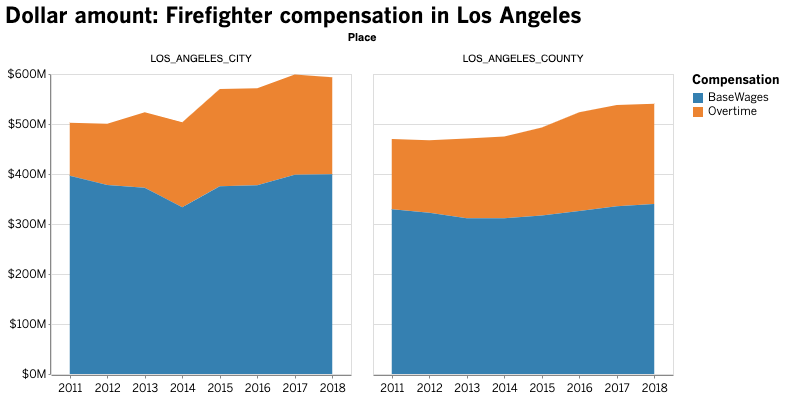

In [14]:
alt.Chart(la_melt).mark_area().encode(
    x=alt.X("Year:N", title=' '),
    y=alt.Y("Total:Q", title=' ', axis=alt.Axis(tickCount=6, format='$,s')),
    color="Compensation:N",
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Compensation',
      sort='ascending'
    ),
    facet='Place:N'
).properties(width=300, height=300, columns=2, title='Dollar amount: Firefighter compensation in Los Angeles')

### Normalized version

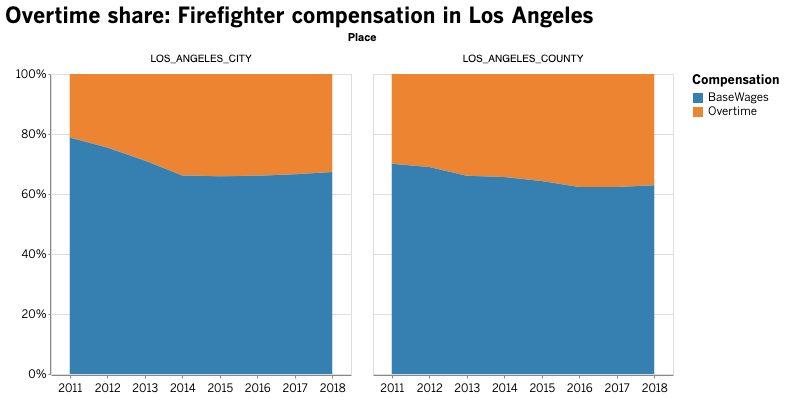

In [15]:
alt.Chart(la_melt).mark_area().encode(
    x=alt.X("Year:N", title=' '),
    y=alt.Y("Total:Q", stack="normalize", title=' ', axis=alt.Axis(tickCount=6, format='%')),
    color="Compensation:N",
    order=alt.Order(
      # Sort the segments of the bars by this field
      'Compensation',
      sort='ascending'
    ),
    facet='Place:N'
).properties(width=300, height=300, columns=2, title='Overtime share: Firefighter compensation in Los Angeles')

In [16]:
la_melt.sort_values(by=['Place', 'Compensation']).to_csv('output/la_melt.csv')

---

### Individual overtime

In [17]:
la_highest = la[la['overtime'] > 200000]

In [18]:
len(la_highest)

165

In [19]:
la_high = la[la['overtime'] > 100000]

In [20]:
len(la_high)

5022

In [21]:
la_high_years = la_high.groupby(['year','type']).agg('size').reset_index(name='count')

In [22]:
la_high_years.sort_values(by='type', ascending=False).head(16)

,year,type,count
1,2011,COUNTY,20
3,2012,COUNTY,58
5,2013,COUNTY,161
7,2014,COUNTY,220
9,2015,COUNTY,408
11,2016,COUNTY,577
13,2017,COUNTY,631
15,2018,COUNTY,611
0,2011,CITY,21
2,2012,CITY,49


In [23]:
la_high_positions = la_high.groupby('position').agg({'adjusted_overtime':'sum', \
                                            'adjusted_basewages':'sum', \
                                        'adjusted_wages':'sum', \
                                            'adjusted_benefits':'sum'\
                                            }).reset_index()

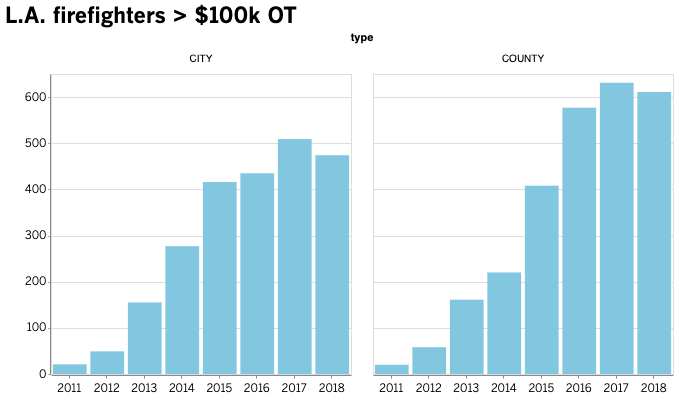

In [28]:
alt.Chart(la_high_years).mark_bar().encode(
    x=alt.X("year:N", title=' '),
    y=alt.Y("mean(count):Q", title=' ', axis=alt.Axis(tickCount=6, format='')),
    facet='type:O'
).properties(width=300, height=300, columns=2, title='L.A. firefighters > $100k OT')

In [29]:
la_high_positions.head(10)

,position,adjusted_overtime,adjusted_basewages,adjusted_wages,adjusted_benefits
0,APPARATUS OPERATOR,"12,821,127","11,847,686","24,668,813","2,563,132"
1,BATTALION CHIEF/56 HOURS/,"31,975,392","40,562,865","72,538,257","19,664,151"
2,ENGINEER OF FIRE DEPARTMENT,"29,327,375","27,134,117","56,461,492","5,456,447"
3,FIRE ASSISTANT CHIEF,"1,201,637","2,090,728","3,292,365","628,553"
4,FIRE BATTALION CHIEF,"15,743,671","20,729,379","36,473,050","3,715,047"
5,FIRE CAPTAIN (56 HOUR),"171,225,657","176,960,584","348,186,241","77,528,270"
6,FIRE CAPTAIN I,"84,006,030","83,818,995","167,825,025","16,675,768"
7,FIRE CAPTAIN II,"37,298,594","38,764,605","76,063,199","7,839,441"
8,FIRE CAPTAIN III,"7,599,785","7,957,654","15,557,439","860,194"
9,FIRE CAPTAIN L,"391,226","420,177","811,403","44,769"


Data source: https://publicpay.ca.gov/Reports/RawExport.aspx